In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
NOTEBOOK_NAME = 'decoding_four_odors_combined_trace'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
#load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [5]:
import glob
animals = [ani[3:] for ani in glob.glob("../*")
           if
           ani != '../img' and
           ani != '../notebooks' and
          ani != '../general notebooks']
print animals

['90', '90_475', '91', '93_500', '93_580', '93_720', '93_810', 'c10m6', 'c10m6_587', 'c10m8', 'c3f3', 'c3m1', 'c3m1_725', 'c3m2', 'c3m2_645', 'dhpcg20', 'dhpcg20_200']


In [6]:
#vhpc_animals = [ani for ani in animals if ani[0]!='d']
vhpc_pre_animals  = 'c3m1', 'c3m2', 'c3f3', 'c10m6','c10m8'
vhpc_post_animals = 'c3m1', 'c3m2', 'c3f3', 'c10m6','c10m8'
#dhpc_animals = [ani for ani in animals if ani[0]=='d']
dhpc_pre_animals  = 'dhpcg20',
dhpc_post_animals = 'dhpcg20',
#print "VENTRAL:", vhpc_animals
print vhpc_pre_animals
print "DORSAL:", dhpc_pre_animals

('c3m1', 'c3m2', 'c3f3', 'c10m6', 'c10m8')
DORSAL: ('dhpcg20',)


In [7]:
#for sess in 'pre', 'post':
#    exec("patterns_%s_vhpc = dict(zip(vhpc_%s_animals, [ut.load_variable('patterns_evs',\
#                                                           '../%%s/%s/notebooks/autorestore/decoding_four_odors_trace/'%%ani)\
#                                                  for ani in vhpc_%s_animals]))"%(sess, sess, sess, sess))
#    exec("labels_%s_vhpc = dict(zip(vhpc_%s_animals, [ut.load_variable('labels',\
#                                                         '../%%s/%s/notebooks/autorestore/decoding_four_odors_trace/'%%ani)\
#                                                  for ani in vhpc_%s_animals]))"%(sess, sess, sess, sess))

In [8]:
#for sess in 'pre', 'post':
#    exec("patterns_%s_dhpc = dict(zip(dhpc_animals, [ut.load_variable('patterns_evs',\
#                                                           '../%%s/%s/notebooks/autorestore/decoding_four_odors_trace/'%%ani)\
#                                                  for ani in dhpc_animals]))"%(sess, sess))
#    exec("labels_%s_dhpc = dict(zip(dhpc_animals, [ut.load_variable('labels',\
#                                                         '../%%s/%s/notebooks/autorestore/decoding_four_odors_trace/'%%ani)\
#                                                  for ani in dhpc_animals]))"%(sess, sess))

In [9]:
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
import numpy as np
cv = LeaveOneOut()

decoder = LinearSVC()

In [10]:
classes = range(1,5)

In [11]:
import h5py

def load_decoding_data(animals, session, notebook, cellreg=False):
#     patterns = dict(zip(animals, [ut.load_variable('patterns_evs', '../%s/%s/notebooks/autorestore/%s/'%(ani, session, notebook))
#                                     for ani in animals]))
#     labels = dict(zip(animals, [ut.load_variable('labels', '../%s/%s/notebooks/autorestore/%s/'%(ani, session, notebook))
#                                         for ani in animals]))
    
    patterns = ut.load_all_animals_vars('patterns_evs', animals, session, notebook,)
    labels = ut.load_all_animals_vars('labels', animals, session, notebook)
    if cellreg:
        cellregs = {}
        for ani in animals:
            try:
                cellregs[ani] = load_cellreg(ani)
            except IOError:
                raise Exception("Cannot find cellreg data for %s."%ani)
        for k, v in patterns.items():
            patterns[k] = patterns[k][:, cellregs[k][session]]
    else:
        cellregs = None

    return patterns, labels


def do_decoding_combined_within(animals, session, notebook, n_loops=10, ncells=None, cellreg=False, n_steps=15, **args):
    
    patterns, labels = load_decoding_data(animals, session, notebook, cellreg)
    
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in animals])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):
#     which_train = range(90)
#     which_test = range(90)

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if relabel_test is not None:
        labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
    else:
        if relabel is not None:
            labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
        else:
            labels_comb_test = labels_comb_test_
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test

    return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
            patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
        
def do_test_within(patterns, labels, **args):
    x, y, xT, yT = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)

def do_test_across(patterns_train, labels_train, patterns_test, labels_test, **args):
    x, y, _, _ = combine_train_test_patterns(patterns_train, labels_train, train_test_split=1, **args)
    xT, yT, _, _ = combine_train_test_patterns(patterns_test, labels_test, train_test_split=1, **args)
    decoder.fit(x, t)
    return decoder.score(xT, yT)

In [12]:
#for confusion matrix (use predict instead of score)
def do_prediction_combined_within(animals, session, notebook, ncells=None, cellreg=False, n_steps=15, **args):
    
    patterns, labels = load_decoding_data(animals, session, notebook, cellreg)
    
    scores, test_labels = do_predict_within(patterns, labels, **args) #had to remove n_loops to be able to extract 'test_labels'
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in animals])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_predict_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, test_labels, ncells, scores_ncells

def do_predict_within(patterns, labels, **args):
    x, y, xT, test_labels = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.predict(xT), test_labels

In [13]:
#predictions_vhpc_post, test_labels_post, ncells, predictions_vhpc_post_ncells = do_prediction_combined_within(vhpc_post_animals, 'post', 'decoding_four_odors_trace',
#                                                                  classes=range(1, 5))
#predictions_vhpc_pre, test_labels_pre, ncells, predictions_vhpc_pre_ncells = do_prediction_combined_within(vhpc_pre_animals, 'pre', 'decoding_four_odors_trace',
#                                                                classes=range(1, 5))

In [14]:
#conf_matr_post = confusion_matrix(predictions_vhpc_post, test_labels_post)
#conf_matr_pre = confusion_matrix(predictions_vhpc_pre, test_labels_pre)

# now loop and concatenate results to get "average" predictions

In [15]:
loops=200

In [16]:
%%time
for i in range(loops+1):
    exec("predictions_vhpc_post_%s, test_labels_post_%s, ncells, predictions_vhpc_post_ncells_%s = do_prediction_combined_within(vhpc_post_animals, 'post', 'decoding_four_odors_trace',classes=range(1, 5))"%(i,i,i))
    exec("predictions_vhpc_pre_%s,  test_labels_pre_%s,  ncells, predictions_vhpc_pre_ncells_%s  = do_prediction_combined_within(vhpc_pre_animals, 'pre', 'decoding_four_odors_trace',classes=range(1, 5))"%(i,i,i))

CPU times: user 13h 27s, sys: 1h 34min 39s, total: 14h 35min 7s
Wall time: 1h 15min 5s


In [17]:
predictions_vhpc_post_appended = np.append(predictions_vhpc_post_1,predictions_vhpc_post_2)
test_labels_post_appended = np.append(test_labels_post_1,test_labels_post_2)
for i in range (3,loops+1):
    exec("predictions_vhpc_post_appended = np.append(predictions_vhpc_post_appended,predictions_vhpc_post_%s)"%i)
    exec("test_labels_post_appended = np.append(test_labels_post_appended,test_labels_post_%s)"%i)

In [18]:
predictions_vhpc_pre_appended = np.append(predictions_vhpc_pre_1,predictions_vhpc_pre_2)
test_labels_pre_appended = np.append(test_labels_pre_1,test_labels_pre_2)
for i in range (3,loops+1):
    exec("predictions_vhpc_pre_appended = np.append(predictions_vhpc_pre_appended,predictions_vhpc_pre_%s)"%i)
    exec("test_labels_pre_appended = np.append(test_labels_pre_appended,test_labels_pre_%s)"%i)

In [19]:
conf_matr_vhpc_post_appended = confusion_matrix(predictions_vhpc_post_appended, test_labels_post_appended)
conf_matr_vhpc_pre_appended = confusion_matrix(predictions_vhpc_pre_appended, test_labels_pre_appended)

In [20]:
conf_matr_vhpc_pre_appended

array([[16692,  1507,  1296,  1016],
       [ 1378, 14716,  1441,  2515],
       [ 1080,  1272, 13481,  4092],
       [  850,  2505,  3782, 12377]])

In [21]:
conf_matr_vhpc_post_appended

array([[18502,   702,   663,   848],
       [  727, 18179,   288,   829],
       [  411,   314, 14786,  3649],
       [  360,   805,  4263, 14674]])

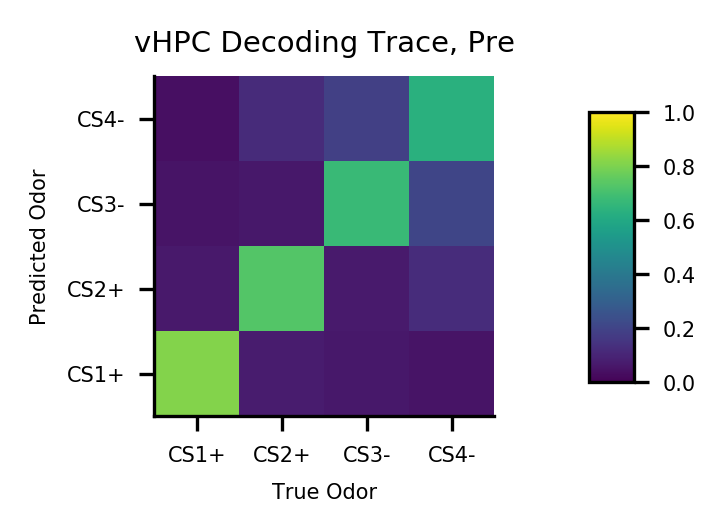

In [22]:
fig, ax = pl.subplots(1, 1, figsize=(1.5, 1.5))

im = ax.imshow(1.*conf_matr_vhpc_pre_appended/np.sum(conf_matr_vhpc_pre_appended, 1), vmin=0, vmax=1, origin='lower')

# axs[0].set_xticks(range(len(np.unique(labels))))
# axs[0].set_yticks(range(len(np.unique(labels))))

# axs[0].set_xticklabels(np.arange(len(np.unique(labels)))+1)
# axs[0].set_yticklabels(np.arange(len(np.unique(labels)))+1)

ax.set_xticks(range(4))
ax.set_yticks(range(4))
ax.set_xticklabels(['CS1+','CS2+', 'CS3-', 'CS4-'])
ax.set_yticklabels(['CS1+','CS2+', 'CS3-', 'CS4-'])

# axs[0].set_xticklabels(np.arange(len(np.unique(labels)))+1)
# axs[0].set_yticklabels(np.arange(len(np.unique(labels)))+1)

ax.set_title('vHPC Decoding Trace, Pre', fontsize=7)

ax.set_xlabel('True Odor', fontsize=5)
ax.set_ylabel('Predicted Odor', fontsize=5)

cax = fig.add_axes([1.1, 0.2, 0.1, 0.6])
fig.colorbar(im, cax=cax)

# fig.tight_layout()

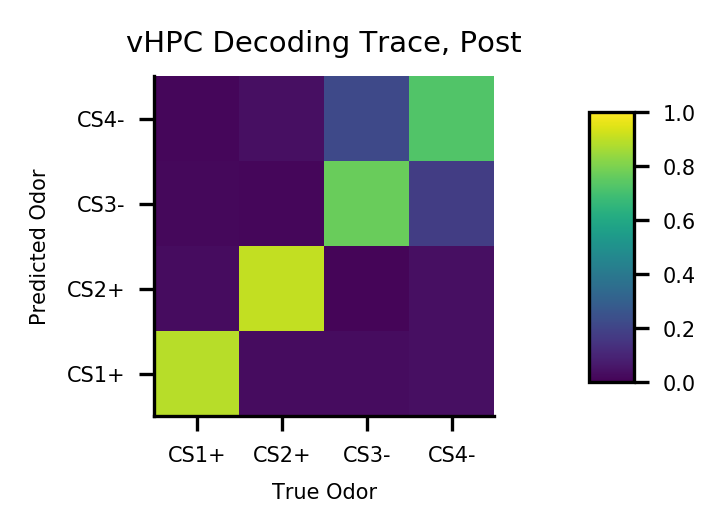

In [23]:
fig, ax = pl.subplots(1, 1, figsize=(1.5, 1.5))

im = ax.imshow(1.*conf_matr_vhpc_post_appended/np.sum(conf_matr_vhpc_post_appended, 1), vmin=0, vmax=1, origin='lower')

# axs[0].set_xticks(range(len(np.unique(labels))))
# axs[0].set_yticks(range(len(np.unique(labels))))

# axs[0].set_xticklabels(np.arange(len(np.unique(labels)))+1)
# axs[0].set_yticklabels(np.arange(len(np.unique(labels)))+1)

ax.set_xticks(range(4))
ax.set_yticks(range(4))
ax.set_xticklabels(['CS1+','CS2+', 'CS3-', 'CS4-'])
ax.set_yticklabels(['CS1+','CS2+', 'CS3-', 'CS4-'])

# axs[0].set_xticklabels(np.arange(len(np.unique(labels)))+1)
# axs[0].set_yticklabels(np.arange(len(np.unique(labels)))+1)

ax.set_title('vHPC Decoding Trace, Post', fontsize=7)

ax.set_xlabel('True Odor', fontsize=5)
ax.set_ylabel('Predicted Odor', fontsize=5)

cax = fig.add_axes([1.1, 0.2, 0.1, 0.6])
fig.colorbar(im, cax=cax)

# fig.tight_layout()

# and now dhpc

In [24]:
%%time
for i in range(loops+1):
    exec("predictions_dhpc_post_%s, test_labels_post_%s, ncells, predictions_dhpc_post_ncells_%s = do_prediction_combined_within(dhpc_post_animals, 'post', 'decoding_four_odors_trace',classes=range(1, 5))"%(i,i,i))
    exec("predictions_dhpc_pre_%s,  test_labels_pre_%s,  ncells, predictions_dhpc_pre_ncells_%s  = do_prediction_combined_within(dhpc_pre_animals, 'pre', 'decoding_four_odors_trace',classes=range(1, 5))"%(i,i,i))

CPU times: user 10h 42min 10s, sys: 1h 42min 12s, total: 12h 24min 23s
Wall time: 1h 19min 5s


In [25]:
predictions_dhpc_post_appended = np.append(predictions_dhpc_post_1,predictions_dhpc_post_2)
test_labels_post_appended = np.append(test_labels_post_1,test_labels_post_2)
for i in range (3,loops+1):
    exec("predictions_dhpc_post_appended = np.append(predictions_dhpc_post_appended,predictions_dhpc_post_%s)"%i)
    exec("test_labels_post_appended = np.append(test_labels_post_appended,test_labels_post_%s)"%i)

In [26]:
predictions_dhpc_pre_appended = np.append(predictions_dhpc_pre_1,predictions_dhpc_pre_2)
test_labels_pre_appended = np.append(test_labels_pre_1,test_labels_pre_2)
for i in range (3,loops+1):
    exec("predictions_dhpc_pre_appended = np.append(predictions_dhpc_pre_appended,predictions_dhpc_pre_%s)"%i)
    exec("test_labels_pre_appended = np.append(test_labels_pre_appended,test_labels_pre_%s)"%i)

In [27]:
conf_matr_dhpc_post_appended = confusion_matrix(predictions_dhpc_post_appended, test_labels_post_appended)
conf_matr_dhpc_pre_appended = confusion_matrix(predictions_dhpc_pre_appended, test_labels_pre_appended)

In [28]:
conf_matr_dhpc_pre_appended

array([[15717,   173,  3288,  1696],
       [  108, 18472,   832,   164],
       [ 2417,   815,  7798,  5506],
       [ 1758,   540,  8082, 12634]])

In [29]:
conf_matr_dhpc_post_appended

array([[18334,    25,   299,   913],
       [  726, 19886,    96,   236],
       [  169,     0, 16519,  3111],
       [  771,    89,  3086, 15740]])

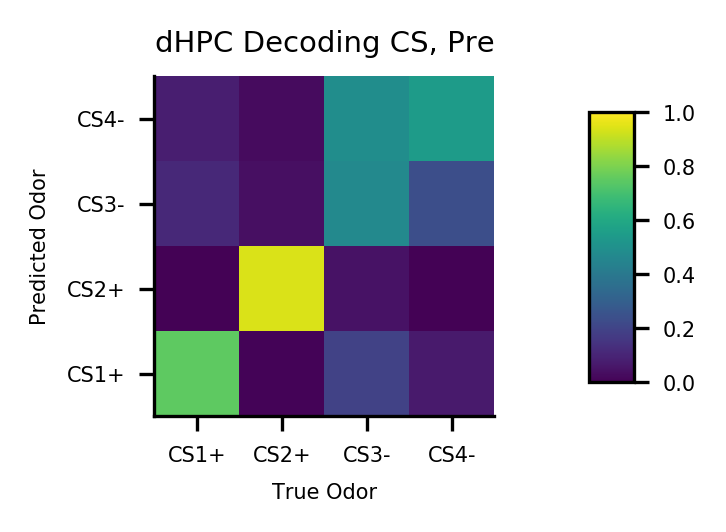

In [33]:
fig, ax = pl.subplots(1, 1, figsize=(1.5, 1.5))

im = ax.imshow(1.*conf_matr_dhpc_pre_appended/np.sum(conf_matr_dhpc_pre_appended, 1), vmin=0, vmax=1, origin='lower')

# axs[0].set_xticks(range(len(np.unique(labels))))
# axs[0].set_yticks(range(len(np.unique(labels))))

# axs[0].set_xticklabels(np.arange(len(np.unique(labels)))+1)
# axs[0].set_yticklabels(np.arange(len(np.unique(labels)))+1)

ax.set_xticks(range(4))
ax.set_yticks(range(4))
ax.set_xticklabels(['CS1+','CS2+', 'CS3-', 'CS4-'])
ax.set_yticklabels(['CS1+','CS2+', 'CS3-', 'CS4-'])

# axs[0].set_xticklabels(np.arange(len(np.unique(labels)))+1)
# axs[0].set_yticklabels(np.arange(len(np.unique(labels)))+1)

ax.set_title('dHPC Decoding CS, Pre', fontsize=7)

ax.set_xlabel('True Odor', fontsize=5)
ax.set_ylabel('Predicted Odor', fontsize=5)

cax = fig.add_axes([1.1, 0.2, 0.1, 0.6])
fig.colorbar(im, cax=cax)

# fig.tight_layout()

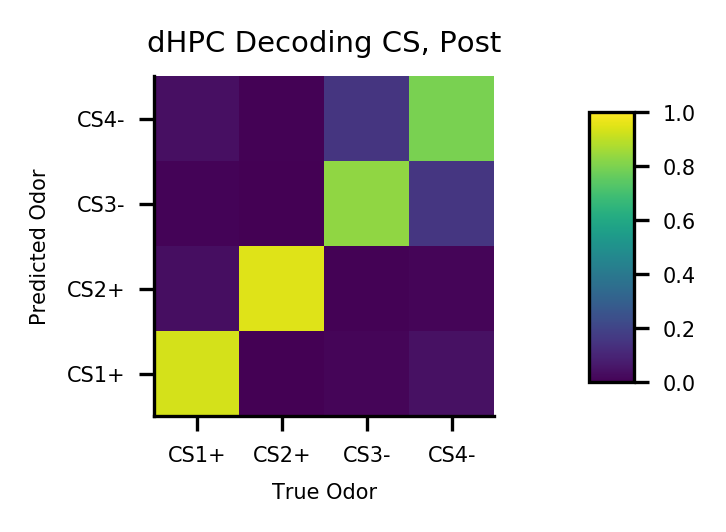

In [34]:
fig, ax = pl.subplots(1, 1, figsize=(1.5, 1.5))

im = ax.imshow(1.*conf_matr_dhpc_post_appended/np.sum(conf_matr_dhpc_post_appended, 1), vmin=0, vmax=1, origin='lower')

# axs[0].set_xticks(range(len(np.unique(labels))))
# axs[0].set_yticks(range(len(np.unique(labels))))

# axs[0].set_xticklabels(np.arange(len(np.unique(labels)))+1)
# axs[0].set_yticklabels(np.arange(len(np.unique(labels)))+1)

ax.set_xticks(range(4))
ax.set_yticks(range(4))
ax.set_xticklabels(['CS1+','CS2+', 'CS3-', 'CS4-'])
ax.set_yticklabels(['CS1+','CS2+', 'CS3-', 'CS4-'])

# axs[0].set_xticklabels(np.arange(len(np.unique(labels)))+1)
# axs[0].set_yticklabels(np.arange(len(np.unique(labels)))+1)

ax.set_title('dHPC Decoding CS, Post', fontsize=7)

ax.set_xlabel('True Odor', fontsize=5)
ax.set_ylabel('Predicted Odor', fontsize=5)

cax = fig.add_axes([1.1, 0.2, 0.1, 0.6])
fig.colorbar(im, cax=cax)

# fig.tight_layout()

In [32]:
save_workspace(db)

Could not store variable 'sstats'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'glob'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'os'. Skipping...
